# Data Exploration of InsideAirbnb.com listings for NY and London


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
from rnd.domain.poc.city import AvailableCity
from rnd.rbnb.data_provider import load_rbnb_listing_data

ny_data = load_rbnb_listing_data(AvailableCity.NEW_YORK)
london_data = load_rbnb_listing_data(AvailableCity.LONDON)


SyntaxError: f-string: unmatched '[' (transform.py, line 39)

In [ ]:
# New York
print("\nNew York Listings - Info:")
# print(ny_data.info())
print(ny_data.head())


In [ ]:
print("\nLondon Listings - Info:")
print(london_data.info())

In [118]:
all_listings = pd.concat([ny_data, london_data], ignore_index=True)
all_listings['data_status'] = all_listings.notna().all(axis=1).map({True: 'Complete', False: 'Incomplete'})


In [ ]:
plt.figure(figsize=(10, 6))

sns.countplot(
    data=all_listings,
    x='city',
    hue=all_listings['price'].isna().map({True: 'Incomplete', False: 'Complete'}),
    palette='viridis'
)

plt.xlabel('City')
plt.ylabel('Count')
plt.title('Completeness of "price" Column by City')
plt.show()


In [ ]:
missing_bed_data = all_listings[['bedrooms', 'beds', 'bathrooms']].isna().any(axis=1)

plt.figure(figsize=(10, 6))

sns.countplot(
    data=all_listings,
    x='city',
    hue=missing_bed_data.map({True: 'Incomplete', False: 'Complete'}),
    palette='viridis'
)

plt.xlabel('City')
plt.ylabel('Count')
plt.title('Completeness of "bedrooms", "beds", and "bathrooms" Columns by City')
plt.show()


In [ ]:
price_summary = all_listings.groupby('city')['price'].agg(
    count='count',
    nan_count=lambda x: x.isna().sum(),
    mean='mean',
    median='median',
    min='min',
    max='max',
    std='std'
).reset_index()
print(price_summary)



plt.figure(figsize=(12, 8))

sns.violinplot(
    data=all_listings,
    x='city',
    y='price',
    palette='Set1'
)

plt.xlabel('City')
plt.ylabel('Price')
plt.title('Price Distribution for Airbnb Listings in New York and London')

plt.show()


In [ ]:
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

cleaned_listings = remove_outliers(all_listings, 'price')
price_summary = cleaned_listings.groupby('city')['price'].agg(
    count='count',
    nan_count=lambda x: x.isna().sum(),
    mean='mean',
    median='median',
    min='min',
    max='max',
    std='std'
).reset_index()
print(price_summary)

plt.figure(figsize=(12, 8))

sns.violinplot(
    data=cleaned_listings,
    x='city',
    y='price',
    palette='Set1'
)

plt.xlabel('City')
plt.ylabel('Price')
plt.title('Price Distribution for Airbnb Listings in New York and London')

plt.show()



In [123]:
import geopandas as gpd
import contextily as ctx
from shapely.geometry import Point
from rnd.rbnb.geospatial_features.transform import landmarks

def plot_map_with_price(df, city: AvailableCity):
    geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
    gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")
    fig, ax = plt.subplots(figsize=(10, 10))
    gdf.plot(column='price', cmap='viridis', legend=True, markersize=0.5, alpha=0.3, ax=ax)
    ctx.add_basemap(ax, crs=gdf.crs)

    if city_landmarks:= landmarks.get(city):
        landmark_df = gpd.GeoDataFrame(
            city_landmarks,
            geometry=[Point(lon, lat) for lon, lat in zip(
                [lm['longitude'] for lm in city_landmarks],
                [lm['latitude'] for lm in city_landmarks]
            )],
            crs="EPSG:4326"
        )
        landmark_df.plot(ax=ax, color='red', marker='*', markersize=100, label='Landmark')

        for _, row in landmark_df.iterrows():
            ax.text(row.geometry.x, row.geometry.y, row['name'], fontsize=8, ha='left', va='bottom', color='red')

    plt.title(f'Property Prices by Location in {city.name.replace("_"," ".capitalize())}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()


In [ ]:
plot_map_with_price(remove_outliers(ny_data, 'price'), AvailableCity.NEW_YORK)
plot_map_with_price(remove_outliers(london_data, 'price'), AvailableCity.LONDON)


#### Categorical columns value exploration for NY and London

In [125]:
ny_data = ny_data.dropna(subset=['price'])
london_data = london_data.dropna(subset=['price'])

print(f"Shape of New York dataset after removing rows with missing price: {ny_data.shape}")
print(f"Shape of London dataset after removing rows with missing price: {london_data.shape}")

Shape of New York dataset after removing rows with missing price: (22969, 36)
Shape of London dataset after removing rows with missing price: (62777, 31)


In [126]:
from collections import Counter
categorical_columns = ['listing_url', 'name', 'description', 'host_is_superhost', 
                      'neighbourhood_cleansed', 'property_type', 'room_type',
                      'instant_bookable', 'city']

def explore_categorical_columns(df:pd.DataFrame, categorical_columns:list[str] = categorical_columns)->None:
    for col in categorical_columns:
        print(f"\n{col}:")
        print("\tNumber of unique values:", df[col].nunique())
        print("\tSample unique values:", df[col].unique()[:5])
        print("\tNumber of missing values:", df[col].isna().sum())
    print("-"*50)
    print("\nCounts of unique values in 'property_type':")
    for key,value in sorted(Counter(df['property_type']).items(), key=lambda x: x[1], reverse=True):
        print(f"{key}: {value}")
    print("\nCounts of unique values in 'neighbourhood_cleansed':")
    for key,value in sorted(Counter(df['neighbourhood_cleansed']).items(), key=lambda x: x[1], reverse=True):
        print(f"{key}: {value}")

In [127]:
explore_categorical_columns(ny_data)


listing_url:
	Number of unique values: 22969
	Sample unique values: ['https://www.airbnb.com/rooms/39572' 'https://www.airbnb.com/rooms/39593'
 'https://www.airbnb.com/rooms/42300' 'https://www.airbnb.com/rooms/42729'
 'https://www.airbnb.com/rooms/43105']
	Number of missing values: 0

name:
	Number of unique values: 22025
	Sample unique values: ['1 br in a 2 br apt (Midtown West)' 'A lovely room w/ a Manhattan view'
 'Beautiful Lower East Side Loft'
 '@HouseOnHenrySt - Private 2nd bedroom w/shared use'
 'Studio 3 blocks from Empire State Building']
	Number of missing values: 0

description:
	Number of unique values: 18444
	Sample unique values: [nan
 'A private, furnished  large room to rent Jan/Feb/25 in an apt unit w/ a city view, near the historic Sunnyside Garden. Subway #7, Q60 & Q32 bus lines in 1.5 blocs; easy transfer to E/F/N/G lines for midtown, downtown & Brooklyn. Availability uncertain from March on (please inquire within). Non-smoking, no-drinking, no-pet woman-to woman

In [128]:
explore_categorical_columns(london_data)


listing_url:
	Number of unique values: 62777
	Sample unique values: ['https://www.airbnb.com/rooms/56229' 'https://www.airbnb.com/rooms/62970'
 'https://www.airbnb.com/rooms/63948' 'https://www.airbnb.com/rooms/66772'
 'https://www.airbnb.com/rooms/69198']
	Number of missing values: 0

name:
	Number of unique values: 60478
	Sample unique values: ['Cosy Double studio in Zone 2 Hammersmith (1)'
 '3 Bedrm with Garden off Brick lane refurbd Oct24'
 'Cosy Double studio in Zone 2 Hammersmith (4)'
 'Cosy Double studio in Zone 2 Hammersmith (3)'
 'Spacious single room in quiet flat']
	Number of missing values: 0

description:
	Number of unique values: 52597
	Sample unique values: [nan
 "Recently renovated  (Oct 2024) warehouse conversion with considerable outside space. The apartment is moments from Brick Lane in Shoreditch! Spacious luxury 3 bedroom & 3 bathroom duplex/maisonette apartment in the centre of arguably London's trendiest & liveliest location. The apt is in Zone 1 and a 5 min wal

#### Preprocessing the categorical features

**neighbourhood_cleansed** - as this might indeed be impactful and informative combined with our geological data (latitude/longitude) we will use label encoding for that, as for both datasets we have quite a few values. Fortunately, we rather don't have a single representants for any subarea - they have at least couple hundred representants which is great for london dataset. On the other hand, NY dataset contains single representants, but we will treat them normally and see how it peerforms.

In [129]:
from sklearn.preprocessing import LabelEncoder

ny_neighbourhood_cleansed_label_encoder = LabelEncoder()
london_neighbourhood_cleansed_label_encoder = LabelEncoder()
ny_data['neighbourhood_cleansed'] = ny_neighbourhood_cleansed_label_encoder.fit_transform(ny_data['neighbourhood_cleansed'])
london_data['neighbourhood_cleansed'] = london_neighbourhood_cleansed_label_encoder.fit_transform(london_data['neighbourhood_cleansed'])


For `property_type` it makes perfect sense to combine it with descriptions, to assign it to one of the groups. For that We've chosen to start with predefined categories and choose the group with highest similarity for each observation. We've predefined couple groups based on initial investigation of the results for those texts.

In [130]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

target_categories = {
    "Luxury": "A luxurious property with premium amenities, high-end furnishings, and exclusive features.",
    "Unique Stay": "A truly unconventional accommodation such as a tent, boat, camper, or other non-standard property. Typically not a traditional home or apartment.",
    "Shared": "A shared room in a rental unit or home, shared home,  where guests share common spaces like the kitchen or living room.",
    "Private Room": "A private room in a home or condo with its own bathroom or entrance.",
    "Entire Home/Apartment": "An entire rental unit, apartment, or condo with full privacy and amenities.",
    "Hotel/Commercial": "A room in a hotel, boutique hotel, or serviced apartment with professional services included (not nearby restaurants)."
}

def assign_property_type_to_df(df: pd.DataFrame, target_column_name: str, target_categories: dict[str,str] = target_categories):
    df['combined_text'] = df['property_type'] + " " + df['description'].fillna("")
    df[target_column_name] = assign_property_type(df, text_column='combined_text', target_categories=target_categories
    )
    df.drop(columns=['combined_text'], inplace=True)
    return df

def assign_property_type(df: pd.DataFrame, text_column : str, target_categories: dict[str,str] = target_categories):
    model = SentenceTransformer('all-MiniLM-L6-v2')

    category_embeddings = {category: model.encode(sentence) for category, sentence in target_categories.items()}
    text_embeddings = model.encode(df[text_column].fillna("").tolist(), show_progress_bar=True)

    def assign_category(embedding):
        similarities = {category: cosine_similarity([embedding], [category_embedding])[0][0]
                        for category, category_embedding in category_embeddings.items()}
        return max(similarities, key=similarities.get)

    return pd.Series([assign_category(embedding) for embedding in text_embeddings], index=df.index)

def print_labeling_results(data: pd.DataFrame, test_results: pd.Series):
    print("\nLabeling Results:")
    print("-" * 120)
    print(f"{'Index':<10} {'Property Type':<30} {'Assigned Category':<20} {'Description':<50}")
    print("-" * 120)
    for index, row in data.iterrows():
        print(f"{index:<10} {row['property_type']:<30} {test_results[index]:<20} {row['description']}")
        print("-" * 120)

Testing the implementation for labeling the luxury label of the dataset

In [131]:
test_data = ny_data.sample(10, random_state=42)
test_data['combined_text'] = test_data['property_type'] + " " + test_data['description'].fillna("")

test_results = assign_property_type(test_data, text_column='combined_text')

print_labeling_results(test_data, test_results)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Labeling Results:
------------------------------------------------------------------------------------------------------------------------
Index      Property Type                  Assigned Category    Description                                       
------------------------------------------------------------------------------------------------------------------------
13807      Private room in home           Private Room         Spacious comfort in the heart of Brooklyn.<br />Elegantly renovated apartment. The entrance leads you to an open Kitchen and Living room to your left. Natural sun light exposure, wooden cabinetry & appliances. New wood floors and clean bathroom.
------------------------------------------------------------------------------------------------------------------------
21470      Tiny home                      Shared               Embrace comfort in our inviting Schuylerville Bronx studio, ideal for professionals or couples seeking an extended stay. Unwind on a

#### Labeling NY Data

In [132]:
ny_data = assign_property_type_to_df(ny_data, 'property_type_label')

Batches:   0%|          | 0/718 [00:00<?, ?it/s]


Labeling Results:
------------------------------------------------------------------------------------------------------------------------
Index      Property Type                  Assigned Category    Description                                       
------------------------------------------------------------------------------------------------------------------------
13807      Private room in home           Private Room         Spacious comfort in the heart of Brooklyn.<br />Elegantly renovated apartment. The entrance leads you to an open Kitchen and Living room to your left. Natural sun light exposure, wooden cabinetry & appliances. New wood floors and clean bathroom.
------------------------------------------------------------------------------------------------------------------------
21470      Tiny home                      Shared               Embrace comfort in our inviting Schuylerville Bronx studio, ideal for professionals or couples seeking an extended stay. Unwind on a

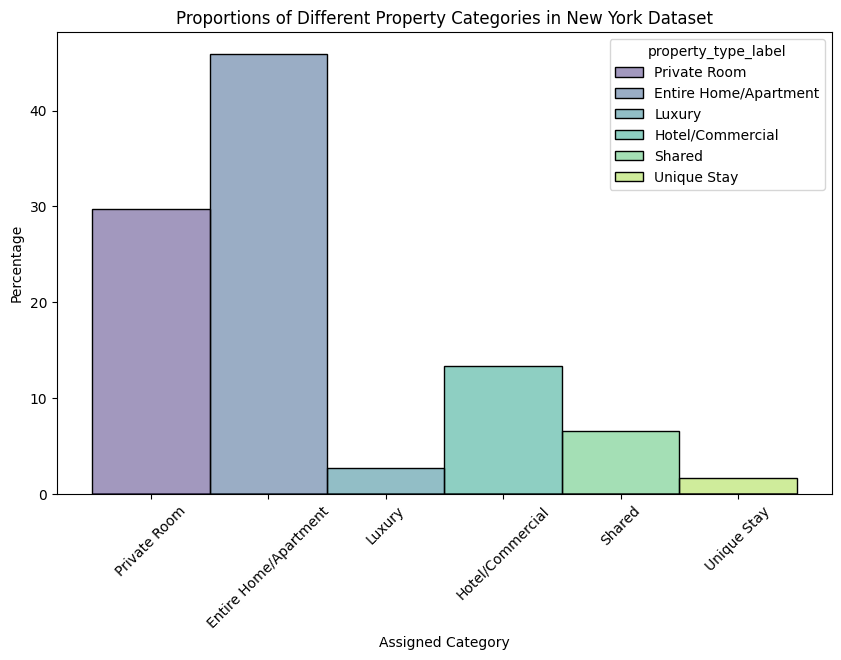

In [133]:
sample_ny_data = ny_data.sample(5, random_state=42)
print_labeling_results(sample_ny_data, ny_data['property_type_label'])

plt.figure(figsize=(10, 6))
sns.histplot(
    data=ny_data,
    x='property_type_label',
    stat='percent',
    discrete=True,
    hue='property_type_label',
    palette='viridis'
)
plt.xlabel('Assigned Category')
plt.ylabel('Percentage')
plt.title('Proportions of Different Property Categories in New York Dataset')
plt.xticks(rotation=45)
plt.show()

#### Labeling London Data

In [134]:
london_data = assign_property_type_to_df(london_data, 'property_type_label')

Batches:   0%|          | 0/1962 [00:00<?, ?it/s]


Labeling Results:
------------------------------------------------------------------------------------------------------------------------
Index      Property Type                  Assigned Category    Description                                       
------------------------------------------------------------------------------------------------------------------------
53855      Entire rental unit             Hotel/Commercial     Enjoy a stylish experience at this centrally-located place.<br /><br />Classy studio apartment located in the famous Notting Hill Area in London.<br /><br />This interior designed apartment is in a grand Victorian townhouse, on a beautiful and quiet tree-lined street<br /><br />One set of towels per person and one set of linen are provided.<br /><br />Feel free to send me a message even if your dates are not available on the calendar.<br /><br />I will do my best to help you.<br /><br />Looking forward to hosting you!
--------------------------------------

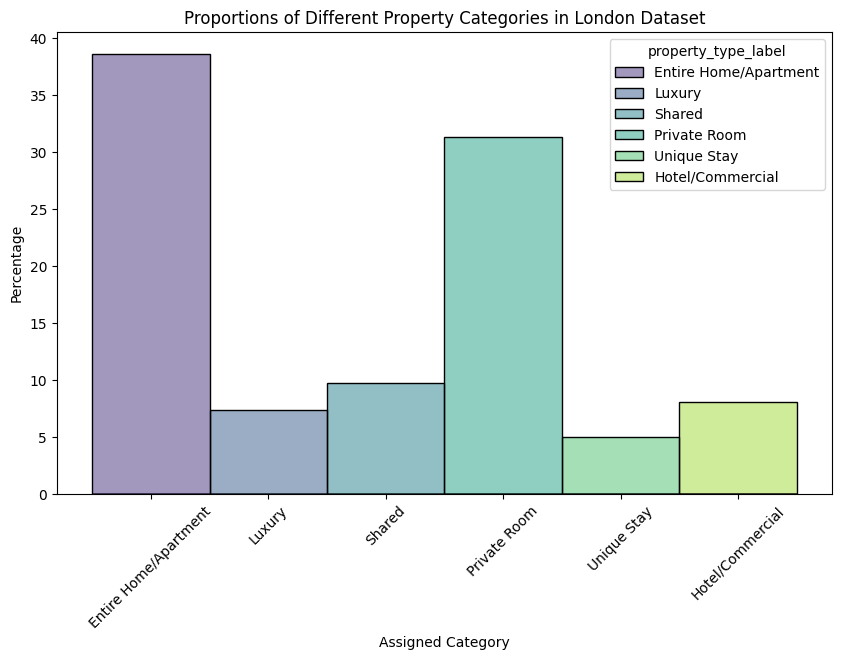

In [135]:
sample_london_data = london_data.sample(5, random_state=42)
print_labeling_results(sample_london_data, london_data['property_type_label'])

plt.figure(figsize=(10, 6))
sns.histplot(
    data=london_data,
    x='property_type_label',
    stat='percent',
    discrete=True,
    hue='property_type_label',
    palette='viridis'
)
plt.xlabel('Assigned Category')
plt.ylabel('Percentage')
plt.title('Proportions of Different Property Categories in London Dataset')
plt.xticks(rotation=45)
plt.show()

### Final data preprocessing and splitting into train and test sets prior to training models

In [151]:
from sklearn.preprocessing import LabelEncoder

ny_property_type_label_encoder = LabelEncoder()
london_property_type_label_encoder = LabelEncoder()
ny_room_type_label_encoder = LabelEncoder()
london_room_type_label_encoder = LabelEncoder()

ny_data['property_type_label'] = ny_property_type_label_encoder.fit_transform(ny_data['property_type_label'])
london_data['property_type_label'] = london_property_type_label_encoder.fit_transform(london_data['property_type_label'])
ny_data['room_type'] = ny_room_type_label_encoder.fit_transform(ny_data['room_type'])
london_data['room_type'] = london_room_type_label_encoder.fit_transform(london_data['room_type'])

In [152]:

columns_to_drop = ['property_type', 'description', 'id', 'host_id',"listing_url","name","city"]

X_ny = ny_data.drop(columns=columns_to_drop, errors='ignore')
X_ny = X_ny.drop(columns=['price'], errors='ignore')
y_ny = ny_data['price']


X_london = london_data.drop(columns=columns_to_drop, errors='ignore')
X_london = X_london.drop(columns=['price'], errors='ignore')
y_london = london_data['price']

#### Training LGMB and evaluating model

In [157]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import lightgbm as lgb

def train_and_evaluate(X, y, drop_null =False, test_size=0.2, random_state=42):
    if drop_null:
        X = X.dropna()
        y = y[X.index]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    model = lgb.LGBMRegressor(num_boost_round=100, verbose=1)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    metrics = {
        "MAE": mean_absolute_error(y_test, y_pred),
        "MSE": mean_squared_error(y_test, y_pred),
        "R2 Score": r2_score(y_test, y_pred)
    }

    return model, metrics

In [ ]:
# import lightgbm as lgb
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# def preprocess_and_train(df, target_col="price"):
#     df = df.copy()

#     # Clean column names: remove spaces and special characters
#     df.columns = df.columns.str.strip().str.replace(r"[^a-zA-Z0-9_]", "_", regex=True)
#     df.columns = df.columns.str.replace(r"__+", "_", regex=True)  # Replace multiple underscores
#     df.columns = df.columns.str.strip("_")  # Remove leading/trailing underscores

#     # Convert categorical variables to one-hot encoding
#     categorical_cols = df.select_dtypes(include=["object", "bool"]).columns
#     df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

#     df.columns = df.columns.str.replace(r"[^a-zA-Z0-9_]", "_", regex=True)

#     def make_unique(column_names):
#         seen = {}
#         unique_names = []
#         for col in column_names:
#             if col in seen:
#                 seen[col] += 1
#                 unique_names.append(f"{col}_{seen[col]}")
#             else:
#                 seen[col] = 0
#                 unique_names.append(col)
#         return unique_names

#     df.columns = make_unique(df.columns)
#     print(df.columns)

#     # Split data into features and target
#     X = df.drop(columns=[target_col, "id", "listing_url", "name", "description", "city"], errors='ignore')
#     y = df[target_col]

#     # Sample only 100 rows for quick validation
#     X_sample, y_sample = X.iloc[:100], y.iloc[:100]

#     X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.2, random_state=42)

#     # Train LightGBM model
#     model = lgb.LGBMRegressor(n_estimators=100, verbose=1)
#     model.fit(X_train, y_train)

#     # Predictions
#     y_pred = model.predict(X_test)

#     # Evaluation metrics
#     metrics = {
#         "MAE": mean_absolute_error(y_test, y_pred),
#         "MSE": mean_squared_error(y_test, y_pred),
#         "R2 Score": r2_score(y_test, y_pred)
#     }

#     return model, metrics

In [ ]:
print(train_and_evaluate(X_ny, y_ny)[1])
print(train_and_evaluate(X_ny, y_ny, drop_null=True)[1])

In [ ]:
print(train_and_evaluate(X_london, y_london)[1])
print(train_and_evaluate(X_london, y_london, drop_null=True)[1])

### Training LightGBM on New York listing data without additional geospartial features

In [166]:
X_ny_without_geo_features = X_ny.loc[:, ~X_ny.columns.str.contains("dist", case=False)]
X_london_without_geo_features = X_london.loc[:, ~X_london.columns.str.contains("dist", case=False)]

print("London, Shape without geo features:", X_london_without_geo_features.shape)
print("New York, Shape without geo features:", X_ny_without_geo_features.shape)
print("London, Shape with geo features:", X_london.shape)
print("New York, Shape with geo features:", X_ny.shape)

London, Shape without geo features: (62777, 15)
New York, Shape without geo features: (22969, 15)
London, Shape with geo features: (62777, 24)
New York, Shape with geo features: (22969, 29)


In [170]:
print(train_and_evaluate(X_ny_without_geo_features, y_ny)[1])
print(train_and_evaluate(X_ny_without_geo_features, y_ny, drop_null=True)[1])

[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000884 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1641
[LightGBM] [Info] Number of data points in the train set: 18375, number of used features: 15
[LightGBM] [Info] Start training from score 193.802830
{'MAE': 85.53915712815055, 'MSE': 164452.3000492795, 'R2 Score': 0.17122978695170188}
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000763 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1623
[LightGB

In [169]:
print(train_and_evaluate(X_london_without_geo_features, y_london)[1])
print(train_and_evaluate(X_london_without_geo_features, y_london, drop_null=True)[1])

[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001354 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1539
[LightGBM] [Info] Number of data points in the train set: 50221, number of used features: 15
[LightGBM] [Info] Start training from score 205.550686
{'MAE': 113.09961084106506, 'MSE': 822786.429479781, 'R2 Score': 0.15519182507382068}
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001059 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1526
[LightGB

### Further explorations

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans

In [46]:
def preprocess_text(df):
    df = df.dropna(subset=['description'])
    return df[['description', 'price']].dropna()

descriptions_ny = preprocess_text(ny_data)
descriptions_london = preprocess_text(london_data)

In [ ]:
print(len(descriptions_ny))
print(len(descriptions_london))

In [ ]:
def lda_features(descriptions, num_topics=10):
    vectorizer = CountVectorizer(stop_words='english', max_features=5000)
    doc_term_matrix = vectorizer.fit_transform(descriptions['description'])
    
    lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
    lda_features = lda_model.fit_transform(doc_term_matrix)
    
    return pd.DataFrame(lda_features, columns=[f'topic_{i}' for i in range(num_topics)]), lda_model, vectorizer

lda_ny, lda_model_ny, vectorizer_ny = lda_features(descriptions_ny)
lda_london, lda_model_london, vectorizer_london = lda_features(descriptions_london)

print("LDA Topics (NYC):")
print(lda_ny)

print("LDA Topics (London):")
print(lda_london)

In [ ]:
import numpy as np

def get_top_words(lda_model, vectorizer, num_words=10):
    words = np.array(vectorizer.get_feature_names_out())
    for topic_idx, topic in enumerate(lda_model.components_):
        top_words = words[np.argsort(topic)][-num_words:][::-1]  # Sort and get top words
        print(f"Topic {topic_idx}: {', '.join(top_words)}")

# Extract most common words per topic
get_top_words(lda_model_ny, vectorizer_ny, num_words=10)

In [ ]:
from sklearn.linear_model import LinearRegression

X = lda_ny  # Topic distribution per listing
y = descriptions_ny['price']  # Target variable (price)

model = LinearRegression()
model.fit(X, y)

# Get topic influence on price
topic_importance = pd.Series(model.coef_, index=[f'topic_{i}' for i in range(10)])
print(topic_importance.sort_values(ascending=False))


In [ ]:
# def bert_features(descriptions, num_clusters=10):
#     model = SentenceTransformer('all-MiniLM-L6-v2')
#     embeddings = model.encode(descriptions, show_progress_bar=True)
    
#     kmeans = KMeans(n_clusters=num_clusters, random_state=42)
#     clusters = kmeans.fit_predict(embeddings)
    
#     clusters_df = pd.DataFrame({'cluster': clusters})
    
#     descriptions_reset = pd.Series(descriptions).reset_index(drop=True)
#     clusters_df.reset_index(drop=True, inplace=True)

#     return pd.concat([descriptions_reset, clusters_df], axis=1)


# descriptions_ny_list = descriptions_ny['description'].tolist()
# descriptions_london_list = descriptions_london['description'].tolist()



# bert_ny = bert_features(descriptions_ny_list)
# bert_london = bert_features(descriptions_london_list)


In [ ]:
# display(bert_ny)

In [ ]:
# ny_final = pd.concat([descriptions_ny.reset_index(drop=True), lda_ny, bert_ny], axis=1)
# london_final = pd.concat([descriptions_london.reset_index(drop=True), lda_london, bert_london], axis=1)

In [ ]:
from transformers import BertTokenizer, BertModel
import torch

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')
bert_model.eval()

In [2]:
def get_bert_embedding(text, tokenizer, model, max_length=128):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=max_length)
    with torch.no_grad():
        outputs = model(**inputs)
    cls_embedding = outputs.last_hidden_state[:, 0, :]  # [CLS] token
    return cls_embedding.squeeze().numpy()


In [4]:
import numpy as np
from tqdm import tqdm

def generate_bert_embeddings(df, column="description"):
    embeddings = []
    for text in tqdm(df[column].fillna("").astype(str), desc="BERT Embedding"):
        emb = get_bert_embedding(text, tokenizer, bert_model)
        embeddings.append(emb)
    return np.vstack(embeddings)

In [15]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np

def preprocess_tabular(df, target_col="price"):
    df = df.copy()

    df.columns = df.columns.str.strip().str.replace(r"[^a-zA-Z0-9_]", "_", regex=True)
    df.columns = df.columns.str.replace(r"__+", "_", regex=True).str.strip("_")

    # Convert categorical variables
    categorical_cols = df.select_dtypes(include=["object", "bool"]).columns
    df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

    def make_unique(column_names):
        seen = {}
        unique_names = []
        for col in column_names:
            if col in seen:
                seen[col] += 1
                unique_names.append(f"{col}_{seen[col]}")
            else:
                seen[col] = 0
                unique_names.append(col)
        return unique_names

    df.columns = make_unique(df.columns)

    # Split features and target
    X = df.drop(columns=[target_col, "id", "listing_url", "name", "description", "city"], errors='ignore')
    y = df[target_col]

    return X, y

def train_with_bert_features(df, bert_embeddings, target_col="price", pca_dim=64):
    # Preprocess tabular features
    X_tabular, y = preprocess_tabular(df, target_col)

    # Optional: Reduce dimensionality of BERT embeddings
    # if pca_dim is not None and bert_embeddings.shape[1] > pca_dim:
    #     pca = PCA(n_components=pca_dim, random_state=42)
    #     bert_embeddings = pca.fit_transform(bert_embeddings)

    # Combine tabular and text features
    X_combined = np.hstack([X_tabular.values, bert_embeddings])

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

    # Train LightGBM model
    model = lgb.LGBMRegressor(num_boost_round=100, verbose=1)
    model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_test)

    # Evaluation
    metrics = {
        "MAE": mean_absolute_error(y_test, y_pred),
        "MSE": mean_squared_error(y_test, y_pred),
        "R2 Score": r2_score(y_test, y_pred)
    }

    return model, metrics


In [ ]:
bert_embeddings = generate_bert_embeddings(df_complete)

df_features = df_complete.drop(columns=["description"])

model_combined, metrics_combined = train_with_bert_features(df_complete, bert_embeddings)

print("Metrics with BERT features:", metrics_combined)
